## Citations_Analysis_publishers_angle

In [113]:
install.packages("reshape")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [317]:
library(ggplot2)
library(plyr)
library(scales)
library(dplyr)
library(stringr)
library(RColorBrewer)
library(httr)
library(tidyr)
library(psych)
library(reshape)



subject,year,count,percentage,sum
copper,2006,32,79,5255
silver,2006,4176,79,5255


In [318]:
load("../data/2018-10-08_source_crossref_meta.Rda",verbose=TRUE)
print((meta$registrants$years[1]))

registrants <- meta$registrants
citation_types <- meta$`citation-types`
relation_types <- meta$`relation-types`
pairings <- meta$pairings
# head(citation_types)

Loading objects:
  meta
[[1]]
     id title sum
1  1990  1990   1
2  1994  1994   1
3  2002  2002   1
4  2003  2003   2
5  2004  2004   3
6  2010  2010   3
7  2011  2011   5
8  2012  2012   9
9  2013  2013  21
10 2014  2014  42
11 2015  2015  75
12 2016  2016 381
13 2017  2017 560
14 2018  2018 609



In [319]:
citation_types<-citation_types %>% unnest(`year-months`) 
head(citation_types)


id,title,count,id1,title1,sum
dataset-scholarly-article,dataset-scholarly-article,6500,1980-06,June 1980,1
dataset-scholarly-article,dataset-scholarly-article,6500,1981-02,February 1981,1
dataset-scholarly-article,dataset-scholarly-article,6500,1981-03,March 1981,1
dataset-scholarly-article,dataset-scholarly-article,6500,1990-04,April 1990,1
dataset-scholarly-article,dataset-scholarly-article,6500,1991-06,June 1991,1
dataset-scholarly-article,dataset-scholarly-article,6500,1991-11,November 1991,1


In [320]:
x

year,total
2009,37
2010,38
2011,64
2012,238
2013,600
2014,536
2015,1003
2016,2274
2017,3671
2018,3021


In [321]:
flat_year<-function(years){
    x <- filter(years[[1]], title == "2016")
    return(x$sum)
}
flat_year_8<-function(years){
    x <- filter(years[[1]], title == "2018")
    return(x$sum)
}

registrants %>%  mutate(`2017` = "",`2018` = "" ) 

for (row in 1:nrow(registrants)) {
    first <- flat_year(registrants$years[row])
    second <- flat_year_8(registrants$years[row])
    if(length(first) == 0){
        first<-0
    }
    if(length(second) == 0){
        second<-0
    }        
        
    registrants$`2017`[row] <- first
    registrants$`2018`[row] <- second
}

registrants<-registrants %>% 
    mutate(m=((`2018`-`2017`)/(10000)), client=title, `2018`=100*(`2018`/count),`2017`=100*(`2017`/count) ) %>% 
    filter(startsWith(title, "crossref")) %>% arrange(desc(`2018`))
(registrants)


id,title,count,years,2017,2018
crossref.297,crossref.297,1713,"1990, 1994, 2002, 2003, 2004, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 1990, 1994, 2002, 2003, 2004, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 1 , 1 , 1 , 2 , 3 , 3 , 5 , 9 , 21 , 42 , 75 , 381 , 560 , 609",,
crossref.4950,crossref.4950,1295,"2012, 2013, 2014, 2015, 2016, 2017, 2018, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 45 , 148 , 11 , 30 , 103 , 547 , 411",,
datacite.bl.f1000r,datacite.bl.f1000r,959,"2014, 2015, 2016, 2017, 2018, 2014, 2015, 2016, 2017, 2018, 5 , 26 , 86 , 476 , 366",,
datacite.gesis.icpsr,datacite.gesis.icpsr,830,"1980, 1981, 1991, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 1980, 1981, 1991, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 1 , 2 , 2 , 3 , 2 , 1 , 1 , 3 , 1 , 5 , 10 , 12 , 17 , 31 , 36 , 2 , 3 , 3 , 4 , 7 , 4 , 19 , 43 , 62 , 100 , 98 , 137 , 125 , 96",,
datacite.dryad.dryad,datacite.dryad.dryad,572,"2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2 , 5 , 17 , 48 , 83 , 193 , 134 , 90",,
crossref.301,crossref.301,492,"1997, 1999, 2000, 2001, 2002, 2003, 2004, 2006, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 1997, 1999, 2000, 2001, 2002, 2003, 2004, 2006, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 1 , 1 , 3 , 3 , 8 , 12 , 12 , 1 , 1 , 6 , 7 , 20 , 28 , 62 , 52 , 94 , 102 , 79",,
datacite.figshare.ars,datacite.figshare.ars,480,"2012, 2013, 2014, 2015, 2016, 2017, 2018, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 45 , 155 , 19 , 34 , 52 , 92 , 83",,
crossref.3145,crossref.3145,470,"2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 1 , 3 , 13 , 4 , 20 , 109 , 232 , 88",,
crossref.13,crossref.13,434,"1996, 1997, 1998, 1999, 2000, 2001, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 1996, 1997, 1998, 1999, 2000, 2001, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 4 , 2 , 5 , 4 , 3 , 9 , 3 , 6 , 3 , 5 , 2 , 13 , 11 , 4 , 3 , 6 , 21 , 27 , 64 , 95 , 100 , 44",,
crossref.311,crossref.311,386,"1980, 1981, 1991, 1993, 1996, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 1980, 1981, 1991, 1993, 1996, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 1 , 2 , 2 , 3 , 1 , 3 , 1 , 2 , 7 , 10 , 2 , 2 , 3 , 2 , 5 , 3 , 4 , 3 , 7 , 26 , 66 , 142 , 68 , 21",,


id,title,count,years,2017,2018,m,client
crossref.1968,crossref.1968,277,"2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2 , 6 , 2 , 2 , 13 , 32 , 80 , 140",11.552347,50.541516,0.0108,crossref.1968
crossref.1965,crossref.1965,79,"2014, 2015, 2016, 2017, 2018, 2014, 2015, 2016, 2017, 2018, 8 , 9 , 12 , 17 , 33",15.189873,41.772152,0.0021,crossref.1965
crossref.297,crossref.297,1713,"1990, 1994, 2002, 2003, 2004, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 1990, 1994, 2002, 2003, 2004, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 1 , 1 , 1 , 2 , 3 , 3 , 5 , 9 , 21 , 42 , 75 , 381 , 560 , 609",22.241681,35.551664,0.0228,crossref.297
crossref.4950,crossref.4950,1295,"2012, 2013, 2014, 2015, 2016, 2017, 2018, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 45 , 148 , 11 , 30 , 103 , 547 , 411",7.953668,31.737452,0.0308,crossref.4950
crossref.292,crossref.292,43,"2014, 2015, 2016, 2017, 2018, 2014, 2015, 2016, 2017, 2018, 2 , 2 , 7 , 19 , 13",16.279070,30.232558,0.0006,crossref.292
crossref.2258,crossref.2258,78,"2011, 2014, 2015, 2016, 2017, 2018, 2011, 2014, 2015, 2016, 2017, 2018, 1 , 1 , 4 , 16 , 36 , 20",20.512821,25.641026,0.0004,crossref.2258
crossref.179,crossref.179,340,"2002, 2003, 2004, 2009, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2002, 2003, 2004, 2009, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2 , 5 , 7 , 1 , 7 , 21 , 37 , 26 , 44 , 60 , 54 , 76",17.647059,22.352941,0.0016,crossref.179
crossref.1913,crossref.1913,35,"2014, 2015, 2016, 2017, 2018, 2014, 2015, 2016, 2017, 2018, 13 , 4 , 8 , 3 , 7",22.857143,20.000000,-0.0001,crossref.1913
crossref.3145,crossref.3145,470,"2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 1 , 3 , 13 , 4 , 20 , 109 , 232 , 88",23.191489,18.723404,-0.0021,crossref.3145
crossref.266,crossref.266,48,"2013, 2014, 2015, 2016, 2017, 2018, 2013, 2014, 2015, 2016, 2017, 2018, 2 , 4 , 7 , 18 , 9 , 8",37.500000,16.666667,-0.0010,crossref.266


In [322]:
# slope_registrants<-registrants %>% 
#     filter(id1=="2017" || id1=="2018") %>%
#     mutate(m=((`2018`-`2017`)/(10000)), client=title, `2018`=`2018`,`2017`=`2017` ) %>% 
#     filter(startsWith(title, "crossref")) %>% arrange(desc(`2018`))
# head(registrants)

In [330]:
# get_registrant_data<-function(registrant) {
#     id<-(str_extract(registrant,'(\\d{2,6})?$'))
#     start <- GET(paste0('https://api.crossref.org/members/',id))
#     parsed <- content(start, "parsed")
#     item <-parsed$message
#     if(is.null(item$`primary-name`)){
#         item$`primary-name`<-""
#     }
# #     return(substr(item$`primary-name`,0,10))
#     return(word(item$`primary-name`, start = 1, end = 2))

# }

# registrants <- registrants %>% rowwise() %>% mutate(registrant_name=get_registrant_data(title))





In [331]:
# crossref_reg<- registrants %>% select(id,registrant_name)
# head(crossref_reg)
# file<-paste0("../data/",Sys.Date(),"_crossref_registrants.Rda")
# print(file)
# save(crossref_reg,file=file)

id,registrant_name
crossref.1968,MDPI AG
crossref.1965,Frontiers Media
crossref.297,Springer Nature
crossref.4950,"F1000 Research,"
crossref.292,Royal Society
crossref.2258,Pensoft Publishers


[1] "../data/2018-10-10_crossref_registrants.Rda"


In [332]:

load("../data/2018-10-10_crossref_registrants.Rda",verbose=TRUE)
registrants <- registrants %>% rowwise() %>% left_join(crossref_reg)

head(registrants_cast)

Loading objects:
  crossref_reg


Joining, by = c("id", "registrant_name")


title,2017,2018
crossref.13,100,44
crossref.179,54,76
crossref.1913,3,7
crossref.1965,17,33
crossref.1968,80,140
crossref.2258,36,20


   vars n  mean  sd median trimmed  mad  min   max range  skew kurtosis   se
X1    1 8 16.78 5.2  16.96   16.78 6.54 7.95 22.86  14.9 -0.35    -1.42 1.84
   vars n  mean    sd median trimmed   mad min   max range skew kurtosis   se
X1    1 8 32.23 10.23  30.99   32.23 10.36  20 50.54 30.54 0.46    -1.23 3.62


[1] 3671

[1] 3021

[1] 3021

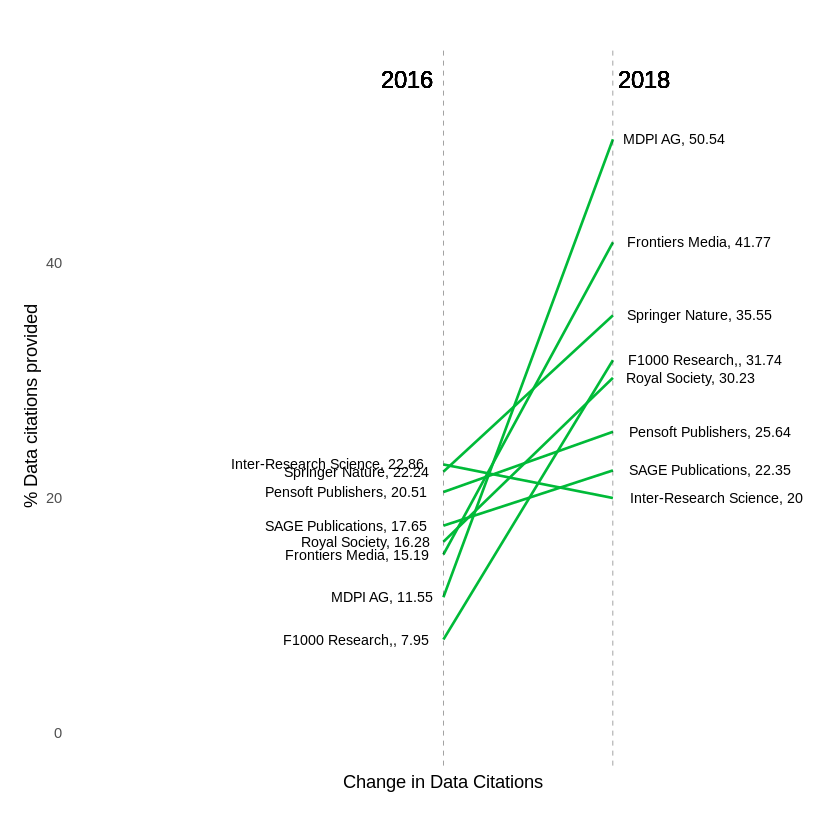

In [335]:
plot_slopegraph<-function(slope_df){
        print(describe(slope_df$`2017`))
        print(describe(slope_df$`2018`))

    left_label <- paste(slope_df$registrant_name, round(slope_df$`2017`, digits = 2),sep=", ")
    right_label <- paste(slope_df$registrant_name, round(slope_df$`2018`, digits = 2),sep=", ")
#     slope_df$class <- ifelse((slope_df$`2018` < slope_df$`2017`), "red", "green")
    slope_df$class <- ifelse((slope_df$`2018` < slope_df$`2017`), "green", "green")

    p <- ggplot(slope_df) + geom_segment(aes(x=1.5, xend=2, y=`2017`, yend=`2018`, col=class), size=.75, show.legend=F) + 
                      geom_vline(xintercept=1.5, linetype="dashed", size=.1) + 
                      geom_vline(xintercept=2, linetype="dashed", size=.1) +
                      scale_color_manual(labels = c("Up", "Down"), 
                                         values = c("green"="#00ba38", "red"="#f8766d")) +  # color of lines
                      labs(x="Change in Data Citations", y="% Data citations provided") +  # Axis labels
                      xlim(.5, 2.5) + ylim(0,(1.1*(max(slope_df$`2017`, slope_df$`2018`))))  # X and Y axis limits

    # Add texts
    p <- p + geom_text(label=left_label, y=slope_df$`2017`, x=rep(1.5, NROW(slope_df)), hjust=1.1, size=3)
    p <- p + geom_text(label=right_label, y=slope_df$`2018`, x=rep(2, NROW(slope_df)), hjust=-0.1, size=3)
    p <- p + geom_text(label="2016", x=1.5, y=1.1*(max(slope_df$`2017`, slope_df$`2018`)), hjust=1.2, size=5)  # title
    p <- p + geom_text(label="2018", x=2, y=1.1*(max(slope_df$`2017`, slope_df$`2018`)), hjust=-0.1, size=5)  # title

    # Minify theme
    p + theme(panel.background = element_blank(), 
               panel.grid = element_blank(),
               axis.ticks = element_blank(),
               axis.text.x = element_blank(),
               panel.border = element_blank(),
               plot.margin = unit(c(1,0.5,1,0.5), "cm"))
}
plot_slopegraph(head(registrants,8))
sum(registrants_cast$`2017`)
sum(registrants_cast$`2018`)
sum(registrants_cast$`2018`)

In [327]:
pairings <- meta$pairings
head(pairings,2)
pairings<-pairings %>% unnest(registrants)  %>% filter(startsWith(title, "crossref")) %>% mutate(datacenter=as.factor(title1),publisher=as.factor(title)) %>% 
    arrange(desc(sum))
pairings <- pairings %>% rowwise() %>% left_join(crossref_reg)
head(pairings,10)

summary(pairings$count)

id,title,count,registrants
crossref.297,crossref.297,1713,"datacite.gesis.icpsr , datacite.dryad.dryad , datacite.figshare.ars , datacite.crui.ingv , datacite.gesis.gesis , datacite.noaa.ncei-ncl , datacite.tib.pangaea , datacite.cern.zenodo , datacite.bl.ukda , datacite.osti.lbnl , datacite.tib.gfz , datacite.usgs.prod , datacite.bl.nerc , datacite.tib.dwd , datacite.delft.data4tu , datacite.cdl.datavers , datacite.esdis.eosdis , datacite.cdl.ciesin , datacite.cdl.ncar , datacite.ornldaac.daac , datacite.tib.wdcc , datacite.edi.edi , datacite.bl.bgi , datacite.gesis.share , datacite.gesis.soep , datacite.bl.mendeley , datacite.delft.vliz , datacite.dk.gbif , datacite.cdl.tcia , datacite.ethz.sed , datacite.osti.nist , datacite.noaa.ncei , datacite.cdl.nsidc , datacite.dartlib.crawdad, datacite.osti.ornlarm , datacite.osti.tessfa , datacite.purdue.ipums , datacite.tib.ukon , datacite.cdl.noaa , datacite.caltech.library, datacite.crui.unile , datacite.gesis.rki , datacite.cdl.mitlcp , datacite.delft.easy , datacite.bl.ccdc , datacite.cdl.bsl , datacite.cdl.tacc , datacite.inist.ifremer , datacite.rg.rg , datacite.gesis.icpsr , datacite.dryad.dryad , datacite.figshare.ars , datacite.crui.ingv , datacite.gesis.gesis , datacite.noaa.ncei-ncl , datacite.tib.pangaea , datacite.cern.zenodo , datacite.bl.ukda , datacite.osti.lbnl , datacite.tib.gfz , datacite.usgs.prod , datacite.bl.nerc , datacite.tib.dwd , datacite.delft.data4tu , datacite.cdl.datavers , datacite.esdis.eosdis , datacite.cdl.ciesin , datacite.cdl.ncar , datacite.ornldaac.daac , datacite.tib.wdcc , datacite.edi.edi , datacite.bl.bgi , datacite.gesis.share , datacite.gesis.soep , datacite.bl.mendeley , datacite.delft.vliz , datacite.dk.gbif , datacite.cdl.tcia , datacite.ethz.sed , datacite.osti.nist , datacite.noaa.ncei , datacite.cdl.nsidc , datacite.dartlib.crawdad, datacite.osti.ornlarm , datacite.osti.tessfa , datacite.purdue.ipums , datacite.tib.ukon , datacite.cdl.noaa , datacite.caltech.library, datacite.crui.unile , datacite.gesis.rki , datacite.cdl.mitlcp , datacite.delft.easy , datacite.bl.ccdc , datacite.cdl.bsl , datacite.cdl.tacc , datacite.inist.ifremer , datacite.rg.rg , 191 , 140 , 96 , 95 , 93 , 82 , 78 , 62 , 59 , 54 , 51 , 40 , 39 , 39 , 35 , 31 , 30 , 28 , 26 , 24 , 21 , 20 , 16 , 15 , 15 , 14 , 14 , 14 , 13 , 12 , 12 , 11 , 10 , 10 , 10 , 10 , 10 , 10 , 8 , 7 , 7 , 7 , 6 , 6 , 5 , 5 , 5 , 5 , 5"
crossref.4950,crossref.4950,1295,"datacite.bl.f1000r , datacite.figshare.ars, datacite.cern.zenodo , datacite.cdl.datavers, datacite.bl.mendeley , datacite.bl.cam , datacite.bl.oxdb , datacite.gesis.ihi , datacite.bl.bgi , datacite.bl.bristol , datacite.bl.ed , datacite.bl.lshtm , datacite.bl.ukda , datacite.cdl.broad , datacite.cdl.tcia , datacite.dryad.dryad , datacite.osti.lbnl , datacite.bl.f1000r , datacite.figshare.ars, datacite.cern.zenodo , datacite.cdl.datavers, datacite.bl.mendeley , datacite.bl.cam , datacite.bl.oxdb , datacite.gesis.ihi , datacite.bl.bgi , datacite.bl.bristol , datacite.bl.ed , datacite.bl.lshtm , datacite.bl.ukda , datacite.cdl.broad , datacite.cdl.tcia , datacite.dryad.dryad , datacite.osti.lbnl , 959 , 243 , 40 , 30 , 8 , 2 , 2 , 2 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1"


Joining, by = "id"


id,title,count,id1,title1,sum,datacenter,publisher,registrant_name
crossref.4950,crossref.4950,1295,datacite.bl.f1000r,datacite.bl.f1000r,959,datacite.bl.f1000r,crossref.4950,F1000 Rese
crossref.4950,crossref.4950,1295,datacite.figshare.ars,datacite.figshare.ars,243,datacite.figshare.ars,crossref.4950,F1000 Rese
crossref.179,crossref.179,340,datacite.gesis.icpsr,datacite.gesis.icpsr,222,datacite.gesis.icpsr,crossref.179,SAGE Publi
crossref.301,crossref.301,492,datacite.gesis.icpsr,datacite.gesis.icpsr,221,datacite.gesis.icpsr,crossref.301,Informa UK
crossref.297,crossref.297,1713,datacite.gesis.icpsr,datacite.gesis.icpsr,191,datacite.gesis.icpsr,crossref.297,Springer N
crossref.311,crossref.311,386,datacite.dryad.dryad,datacite.dryad.dryad,183,datacite.dryad.dryad,crossref.311,Wiley
crossref.3145,crossref.3145,470,datacite.caltech.library,datacite.caltech.library,156,datacite.caltech.library,crossref.3145,Copernicus
crossref.297,crossref.297,1713,datacite.dryad.dryad,datacite.dryad.dryad,140,datacite.dryad.dryad,crossref.297,Springer N
crossref.4374,crossref.4374,142,datacite.dryad.dryad,datacite.dryad.dryad,112,datacite.dryad.dryad,crossref.4374,eLife Scie
crossref.297,crossref.297,1713,datacite.figshare.ars,datacite.figshare.ars,96,datacite.figshare.ars,crossref.297,Springer N


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   35.0    79.0   386.0   482.2   492.0  1713.0 

In [328]:
# https://stats.stackexchange.com/questions/12029/is-it-possible-to-create-parallel-sets-plot-using-r

parallelset <- function(..., freq, col="gray", border=0, layer, 
                             alpha=0.5, gap.width=0.05) {
  p <- data.frame(..., freq, col, border, alpha, stringsAsFactors=FALSE)
  n <- nrow(p)
  if(missing(layer)) { layer <- 1:n }
  p$layer <- layer
  np <- ncol(p) - 5
  d <- p[ , 1:np, drop=FALSE]
  p <- p[ , -c(1:np), drop=FALSE]
  p$freq <- with(p, freq/sum(freq))
  col <- col2rgb(p$col, alpha=TRUE)
  if(!identical(alpha, FALSE)) { col["alpha", ] <- p$alpha*256 }
  p$col <- apply(col, 2, function(x) do.call(rgb, c(as.list(x), maxColorValue = 256)))
  getp <- function(i, d, f, w=gap.width) {
    a <- c(i, (1:ncol(d))[-i])
    o <- do.call(order, d[a])
    x <- c(0, cumsum(f[o])) * (1-w)
    x <- cbind(x[-length(x)], x[-1])
    gap <- cumsum( c(0L, diff(as.numeric(d[o,i])) != 0) )
    gap <- gap / max(gap) * w
    (x + gap)[order(o),]
  }
  dd <- lapply(seq_along(d), getp, d=d, f=p$freq)
  par(mar = c(0, 0, 2, 0) + 0.1, xpd=TRUE )
  plot(NULL, type="n",xlim=c(0, 1), ylim=c(np, 1),
       xaxt="n", yaxt="n", xaxs="i", yaxs="i", xlab='', ylab='', frame=FALSE)
  for(i in rev(order(p$layer)) ) {
     for(j in 1:(np-1) )
     polygon(c(dd[[j]][i,], rev(dd[[j+1]][i,])), c(j, j, j+1, j+1),
             col=p$col[i], border=p$border[i])
   }
   text(0, seq_along(dd), labels=c("Publishers","Data Centers"), adj=c(0,-2), font=2)
   for(j in seq_along(dd)) {
     ax <- lapply(split(dd[[j]], d[,j]), range)
     for(k in seq_along(ax)) {
       lines(ax[[k]], c(j, j))
#          text(ax[[k]][1], j, labels=names(ax)[k], adj=c(0, -0.25))
     }
   }           
}
darkcols <- brewer.pal(8, "Spectral")
pal <-colorRampPalette(brewer.pal(8, "Paired"))
pal

function (n) 
{
    x <- ramp(seq.int(0, 1, length.out = n))
    if (ncol(x) == 4L) 
        rgb(x[, 1L], x[, 2L], x[, 3L], x[, 4L], maxColorValue = 255)
    else rgb(x[, 1L], x[, 2L], x[, 3L], maxColorValue = 255)
}
<bytecode: 0x36f1768>
<environment: 0x6e60888>

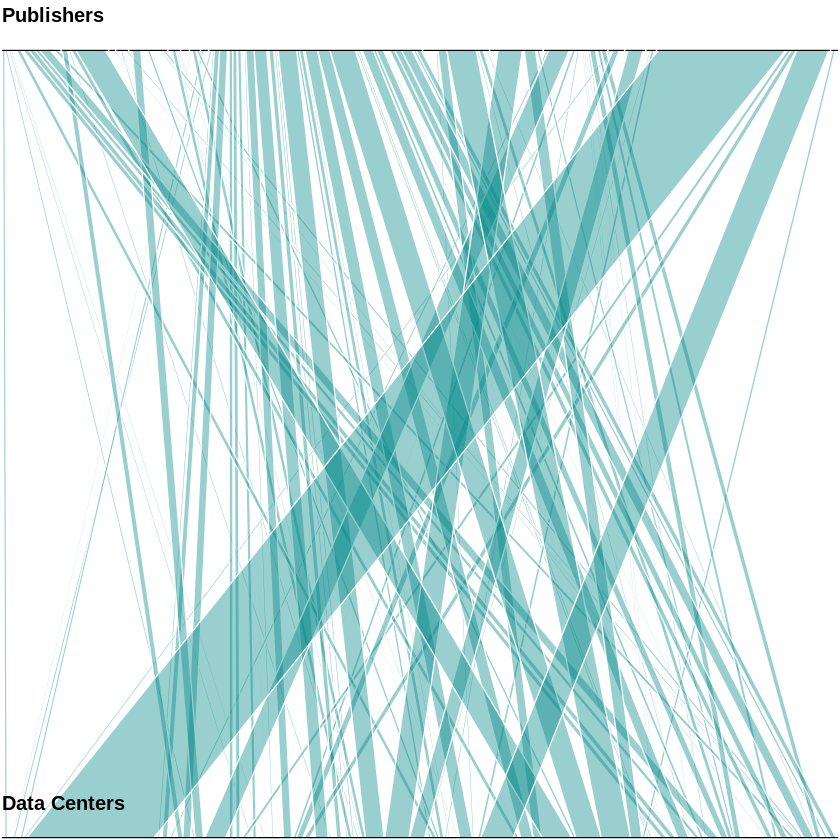

In [81]:
with(pairings, parallelset(publisher,datacenter,  freq=sum, col="#008888", alpha=0.4)) 

# Highlights of top 3

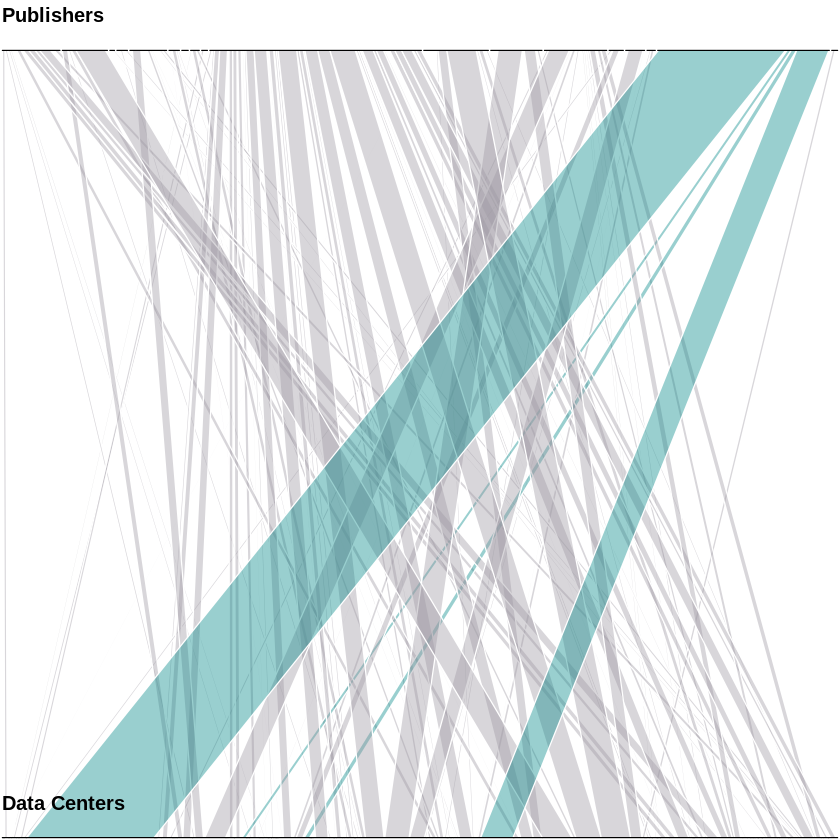

In [82]:
pairings_h <- pairings %>%
    mutate(highlighted = ifelse(publisher=="crossref.4950","Yes","No")) 
    

myt <- within(pairings_h, {
  highlighted <- factor(highlighted, levels=c("Yes","No"))
  color <- ifelse(highlighted=="Yes","#008888","#9e99a3")
})
with(myt, parallelset(publisher, datacenter,  freq=sum, col=color, alpha=0.4)) 

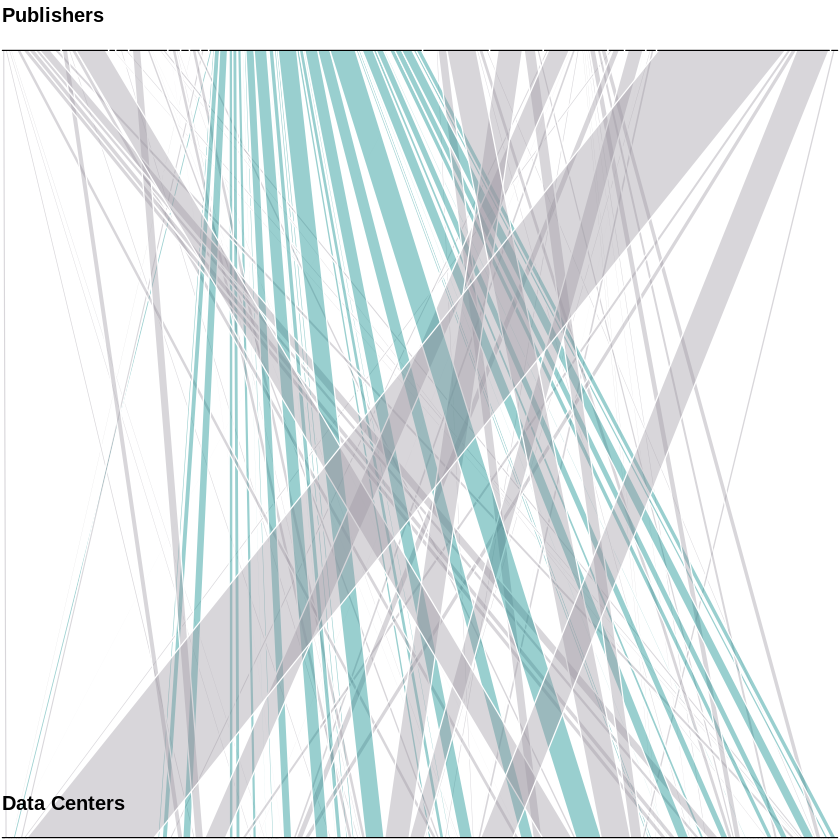

In [83]:
pairings_h <- pairings %>%
    mutate(highlighted = ifelse(publisher=="crossref.297","Yes","No")) 
    

myt <- within(pairings_h, {
  highlighted <- factor(highlighted, levels=c("Yes","No"))
  color <- ifelse(highlighted=="Yes","#008888","#9e99a3")
})
with(myt, parallelset(publisher, datacenter,  freq=sum, col=color, alpha=0.4)) 

# Types Distribution

   vars n  mean sd median trimmed mad   min   max range skew kurtosis se
X1    1 1 53923 NA  53923   53923   0 53923 53923     0   NA       NA NA


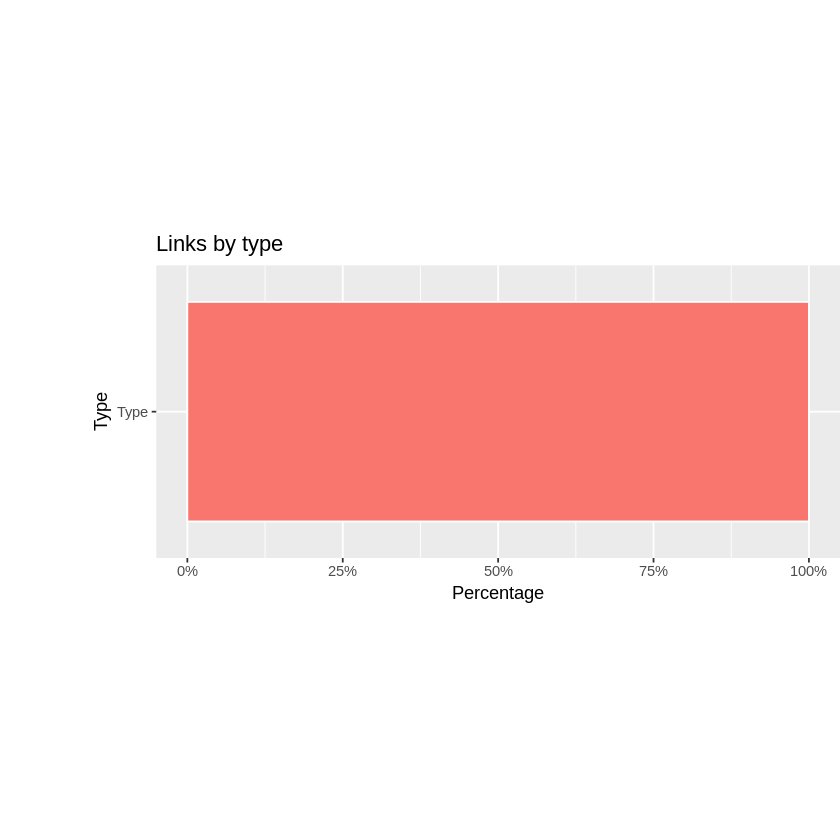

In [4]:
relation_types <- meta$`relation-types`

types <- relation_types %>%   
        mutate(total = sum(count), percentage = (count/total)*100, type=title, column="Type") %>%
        arrange(desc(total))

# head(types)



hundred_plot<-function(types,title,legend_status){
    print(describe(types$count))
    fill <- c("#5F9EA0", "#E1B372", "#E1B373", "#E1B374", "#E1B375", "#E1B376", "#E1B377", "#E1B379", "#E1B379", "#E1B379")
    p4 <- ggplot() + geom_bar(aes(y = percentage, x = column, fill = type), data = (types), show.legend = legend_status,
                               stat="identity", colour="white")   + labs(x="Type", y="Percentage") +
      scale_y_continuous(labels = dollar_format(suffix = "%", prefix = ""))  + 
      ggtitle(title) 
    p4 + coord_flip() + theme(
                   plot.margin = unit(c(5,0,5,2), "cm"), legend.position="bottom", legend.box = "horizontal") 

    #https://stackoverflow.com/questions/34399760/change-color-for-specific-variable-r-ggplot-stacked-bar-chart
}

hundred_plot(types, "Links by type",FALSE)

In [228]:
load("../data/2018-10-09_source_crossref_all_citations_types_meta.Rda",verbose=TRUE)

Loading objects:
  meta


   vars n    mean       sd median trimmed     mad min   max range skew kurtosis
X1    1 7 6013.14 11007.86   1038 6013.14 1372.89 112 30452 30340 1.49     0.51
        se
X1 4160.58


id,title,count,year-months,total,percentage,type,column


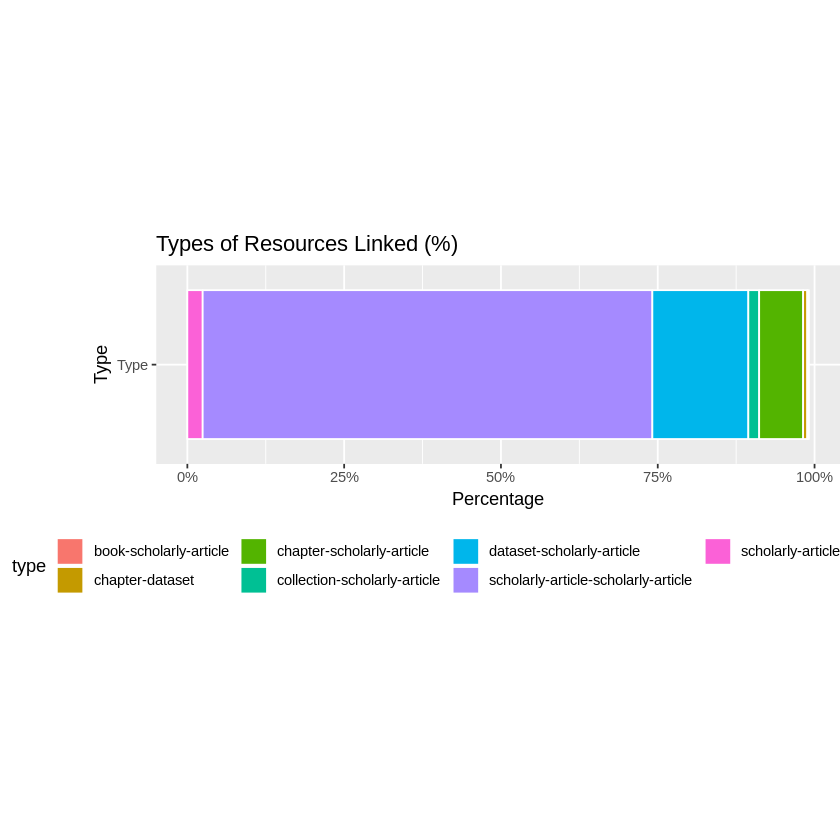

In [229]:
citation_types <- meta$`citation-types`

types <- citation_types %>%   
        mutate(total = sum(count), percentage = (count/total)*100, type=title, column="Type") %>%
        arrange(desc(percentage))
hundred_plot(head(types,7),"Types of Resources Linked (%)",TRUE)
head(types)

In [314]:
load("../data/2018-10-08_source_crossref_meta.Rda",verbose=TRUE)
print((meta$registrants$years[1]))

registrants <- meta$registrants

Loading objects:
  meta
[[1]]
     id title sum
1  1990  1990   1
2  1994  1994   1
3  2002  2002   1
4  2003  2003   2
5  2004  2004   3
6  2010  2010   3
7  2011  2011   5
8  2012  2012   9
9  2013  2013  21
10 2014  2014  42
11 2015  2015  75
12 2016  2016 381
13 2017  2017 560
14 2018  2018 609



In [315]:
registrants<-registrants %>% unnest(`years`) %>% filter(id1>"2008") %>% mutate(year=as.factor(id1),sum=as.integer(sum))
# head(registrants)
# registrants_cast<-cast(registrants, title~id1,sum)
# registrants_cast<-registrants_cast %>% select(title,`2017`,`2018`)
# head(registrants_cast)
x<-group_by(registrants, year) %>% summarise(total = sum(sum))

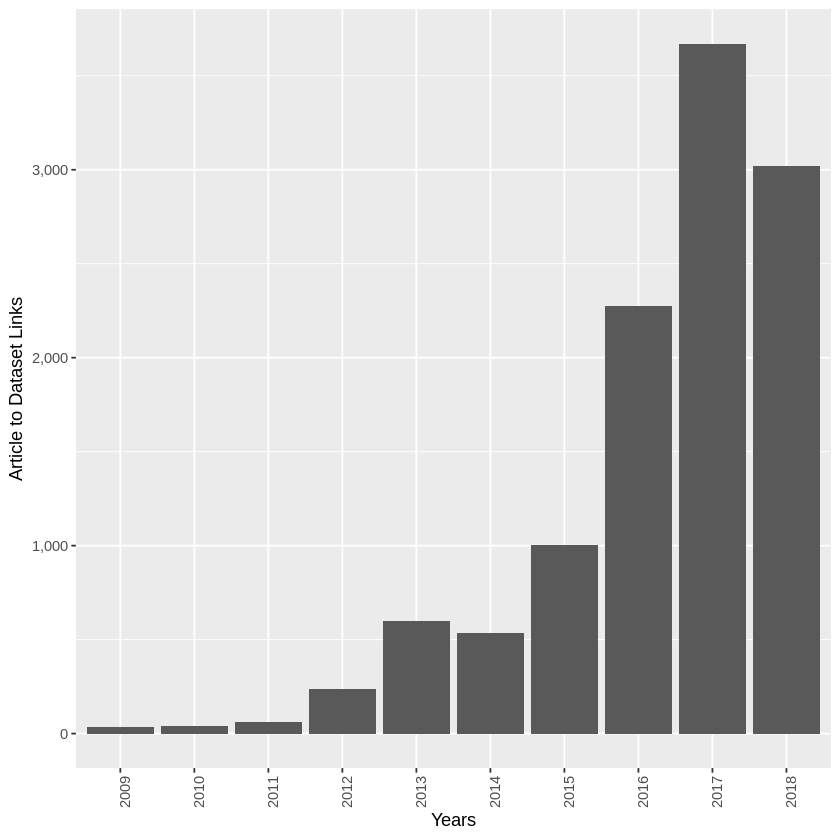

In [316]:
p<-ggplot(x, aes(x=year,y=total)) + geom_bar(stat="identity") + scale_y_continuous(label=comma) +
                      labs(x="Years", y="Article to Dataset Links")  # Axis labels


p + theme( 
              axis.text.x = element_text(angle = 90, hjust = 1)) 
